## Exploration of RISE with mnist binary

Function : Exploration of RISE mnist binary  
Author : Team DIANNA  
Contributor :  
First Built : 2021.08.25  
Last Update : 2021.08.25  
Note : We ran the method using the our own trained model on mnist and various instances from mnist dataset. Results look random. There is no sense that we can make of the heatmaps.

In [9]:
import os
import dianna
import onnx
import onnxruntime
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from scipy.special import softmax
import pandas as pd
from dianna.methods import RISE
from dianna import visualization

In [2]:
# load data
dataset_root = os.path.expanduser('~/projects/DIANNA/datasets/leafsnap/leafsnap-dataset-30subset/')
img_size = 128
# apply same transform as during training: resize and crop to a square image, then convert to tensor
transform = transforms.Compose([transforms.Resize(img_size),
                                transforms.CenterCrop(img_size),
                                transforms.ToTensor()])

test_data = datasets.ImageFolder(os.path.join(dataset_root, 'dataset/split/test'), transform=transform,
                                 is_valid_file=lambda fname: fname.endswith('.jpg'))
nsample = len(test_data)
nspecies = len(test_data.classes)
print(f'Number of samples: {nsample}')
print(f'Number of species: {nspecies}')

X_test = np.array([instance[0].numpy() for instance in test_data])
X_test = np.transpose(X_test, (0, 2, 3, 1))
y_test = np.array([instance[1] for instance in test_data])

Number of samples: 739
Number of species: 30


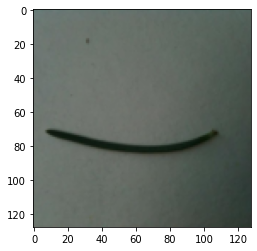

In [3]:
X_test.shape
plt.imshow(X_test[0])

# Predict classes for test data

In [4]:
def run_model(data):
    data = np.transpose(data, (0, 3, 1, 2)).astype(np.float32)
    fname = os.path.expanduser('~/surfdrive/Shared/datasets/leafsnap/leafsnap_model.onnx')
    # get ONNX predictions
    sess = onnxruntime.InferenceSession(fname)
    input_name = sess.get_inputs()[0].name
    output_name = sess.get_outputs()[0].name

    
    onnx_input = {input_name: data}
    pred_onnx = sess.run([output_name], onnx_input)
    
    return softmax(pred_onnx[0], axis=1)


pred_onnx = run_model(X_test)

Print class and image of a single instance in the test data

2
[2.2263842e-11 8.8479817e-07 9.9706697e-01 2.5346053e-03 6.8168029e-06
 9.8773878e-09 6.9872258e-05 2.5941175e-05 2.7593690e-06 4.0837489e-10
 1.5737007e-06 6.1076668e-09 1.4814456e-08 1.3469712e-05 4.6744173e-08
 2.3746741e-08 1.6557478e-05 5.4702246e-06 5.0416776e-07 2.0181572e-11
 1.5110372e-07 1.2924235e-06 3.2731759e-07 3.1940556e-07 9.1364069e-07
 1.0909525e-08 1.2453539e-07 6.8950058e-06 7.5442019e-10 2.4445236e-04]


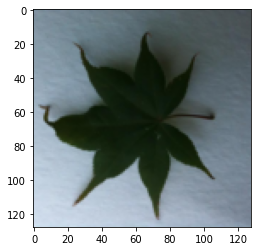

In [5]:
i_instance = 50
target_class = y_test[i_instance]
print(target_class)
print(pred_onnx[i_instance])
plt.imshow(X_test[i_instance])

In [6]:
# heatmaps = dianna.explain(run_model, X_test[[i_instance]], method="RISE", n_masks=2000, feature_res=8)

In [12]:
# investigate which value for p_keep works best by looking at the stddev of the probabilities for the target class,
def print_stats(p_keep):
    n_masks = 100
    feature_res = 8
    explainer = RISE(n_masks=n_masks, feature_res=feature_res, p_keep=p_keep)
    explainer(run_model, X_test[[i_instance]])
    preds = explainer.predictions[:, y_test[i_instance]]
    df = pd.DataFrame(preds)
    display(df.describe())
    
# print_stats(.5)  # stddev 0.04, too low
print_stats(.2)  # stddev .22, min value .14, max value .97. Seems good.

Explaining: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


,0
count,100.000000
mean,0.608432
std,0.221318
min,0.140273
25%,0.448999
50%,0.624676
75%,0.807310
max,0.966200


In [19]:
explainer = RISE(n_masks=2000, feature_res=8, p_keep=.2)
heatmaps = explainer(run_model, X_test[[i_instance]])

Explaining: 100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


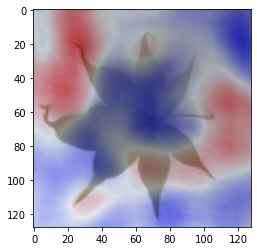

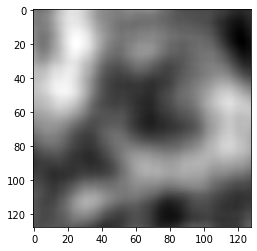

In [20]:
visualization.plot_image(heatmaps[target_class], X_test[i_instance], heatmap_cmap='bwr')
visualization.plot_image(heatmaps[target_class], heatmap_cmap='gray')

# Conclusion
RISE does show some clear structure in the resulting heatmap, but it is not entirely clear how this relates to the shape of the leaf. It might detect mostly the edges of the leaf.

In [9]:
def describe(arr):
    print('shape:',arr.shape, 'min:',np.min(arr), 'max:',np.max(arr), 'std:',np.std(arr))

describe(heatmaps[target_class])
# describe(heatmaps[1])

shape: (128, 128) min: 0.9178498358010488 max: 1.012417010412439 std: 0.014064333127450286


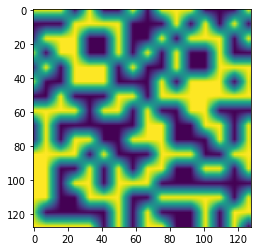

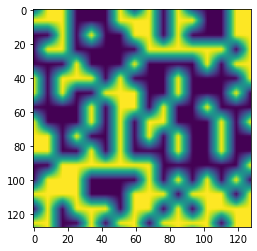

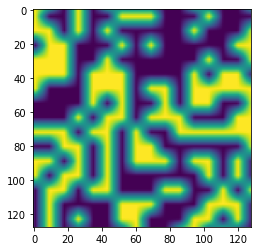

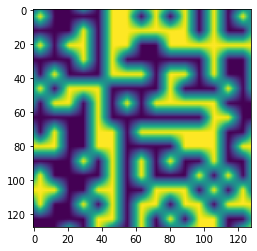

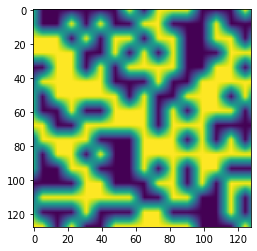

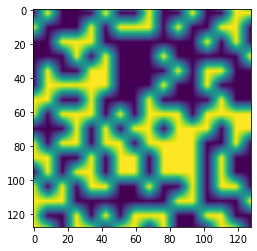

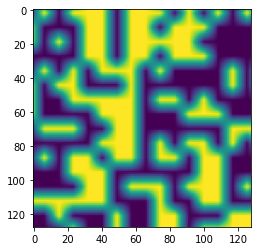

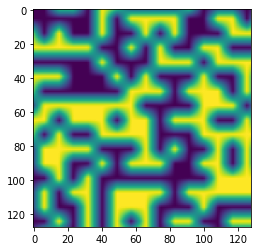

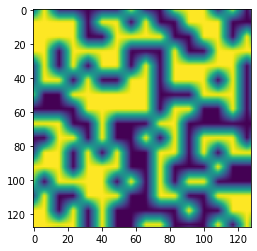

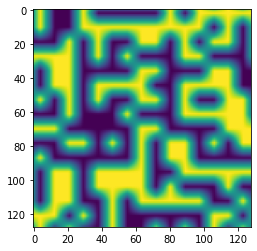

In [10]:
for i in range(10):
    plt.imshow(explainer.masks[i])
    plt.show()